In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('AMZN1.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6679,2023-11-29,147.850006,148.539993,145.970001,146.320007,146.320007,40610900
6680,2023-11-30,144.759995,146.929993,144.330002,146.089996,146.089996,65814000
6681,2023-12-01,146.000000,147.250000,145.550003,147.029999,147.029999,39924600
6682,2023-12-04,145.250000,145.350006,142.809998,144.839996,144.839996,48294200


In [2]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6679,2023-11-29,146.320007
6680,2023-11-30,146.089996
6681,2023-12-01,147.029999
6682,2023-12-04,144.839996


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

<ipython-input-4-27440ea654b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


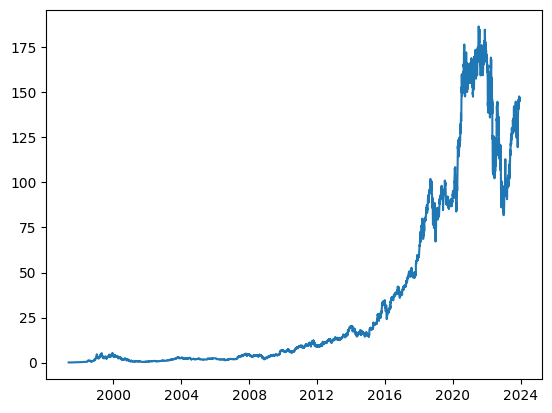

In [4]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [5]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-11-29,146.320007,147.029999,147.729996,146.740005,146.710007,143.899994,146.130005,145.179993
2023-11-30,146.089996,146.320007,147.029999,147.729996,146.740005,146.710007,143.899994,146.130005
2023-12-01,147.029999,146.089996,146.320007,147.029999,147.729996,146.740005,146.710007,143.899994


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.47029999e+02, 1.46089996e+02, 1.46320007e+02, ...,
        1.46740005e+02, 1.46710007e+02, 1.43899994e+02],
       [1.44839996e+02, 1.47029999e+02, 1.46089996e+02, ...,
        1.47729996e+02, 1.46740005e+02, 1.46710007e+02],
       [1.46880005e+02, 1.44839996e+02, 1.47029999e+02, ...,
        1.47029999e+02, 1.47729996e+02, 1.46740005e+02]])

In [7]:
shifted_df_as_np.shape

(6677, 8)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.57597246,  0.56589198,  0.568361  , ...,  0.57286498,
         0.57254329,  0.54240921],
       [ 0.55248713,  0.57597246,  0.5658944 , ...,  0.58348147,
         0.57286498,  0.57254329],
       [ 0.57436394,  0.55248713,  0.57597482, ...,  0.57597482,
         0.58348147,  0.57286498]])

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((6677, 7), (6677,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.54240921,  0.57254329,  0.57286498, ...,  0.57597482,
         0.568361  ,  0.56589198],
       [ 0.57254329,  0.57286498,  0.58348147, ...,  0.568361  ,
         0.5658944 ,  0.57597246],
       [ 0.57286498,  0.58348147,  0.57597482, ...,  0.5658944 ,
         0.57597482,  0.55248713]])

In [11]:
split_index = int(len(X) * 0.95)

split_index

6343

In [12]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6343, 7), (334, 7), (6343,), (334,))

In [13]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6343, 7, 1), (334, 7, 1), (6343, 1), (334, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6343, 7, 1]),
 torch.Size([334, 7, 1]),
 torch.Size([6343, 1]),
 torch.Size([334, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [19]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [20]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [21]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.266
Batch 200, Loss: 0.115
Batch 300, Loss: 0.064

Val Loss: 0.022
***************************************************

Epoch: 2
Batch 100, Loss: 0.013
Batch 200, Loss: 0.008
Batch 300, Loss: 0.006

Val Loss: 0.009
***************************************************

Epoch: 3
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003
Batch 300, Loss: 0.002

Val Loss: 0.007
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.004
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.002
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.003
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.002
*****************

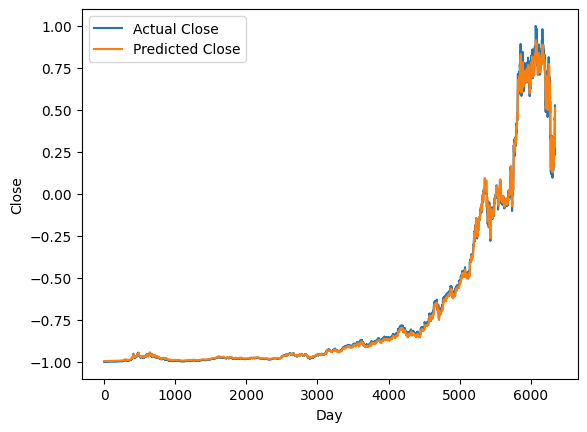

In [22]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [23]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.57228686,   0.5736764 ,   0.57352077, ..., 137.17004256,
       140.10924474, 140.869885  ])

In [24]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.42570009e+02, 1.40800003e+02, 1.39410005e+02])

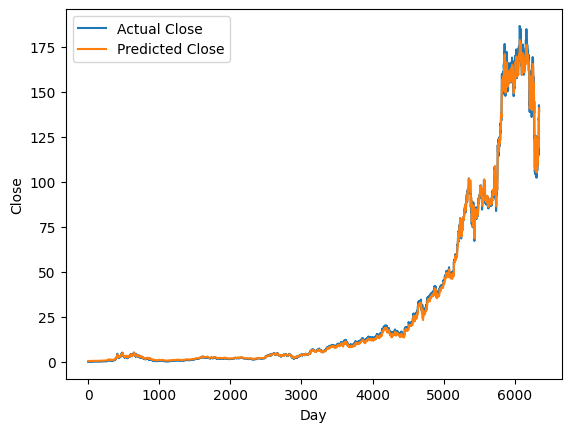

In [25]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [26]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([140.62707284, 139.70490518, 141.29036257, 141.27160391,
       142.55700324, 143.12074143, 144.1241883 , 143.50207314,
       143.22073762, 141.22444879, 137.80450509, 136.02997703,
       135.1555342 , 136.34543386, 134.08968628, 132.39928875,
       130.94818787, 129.22324939, 128.81512752, 128.52406807,
       127.74209573, 128.95075962, 129.80934791, 131.90971815,
       134.53316336, 131.44150187, 130.43957237, 128.75725357,
       126.49802938, 125.85202541, 124.38986387, 121.83517264,
       119.8528069 , 117.05644848, 116.28983185, 115.62704652,
       117.18234275, 116.4896964 , 115.17270747, 115.88358863,
       118.91150263, 120.53033377, 121.04185339, 118.35561251,
       116.31296198, 114.4547272 , 113.87922246, 113.50737708,
       110.50260988, 112.4097895 , 114.8570436 , 115.56908502,
       115.98189794, 118.17323382, 119.56286741, 120.63955922,
       118.70758899, 115.17572275, 109.31250179, 105.65168015,
       100.91834918,  96.11872892,  92.2807032 ,  91.36

In [27]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([137.83000298, 142.69000357, 140.64000103, 143.55000084,
       143.17999102, 144.7799968 , 142.10000324, 142.30000119,
       138.22999608, 133.22000121, 133.61999431, 133.80000247,
       137.27999891, 130.7499991 , 129.78999174, 128.72999653,
       126.76999668, 127.82000117, 127.51000241, 126.11000014,
       129.47999576, 129.82000839, 133.27000486, 136.44999605,
       126.82000034, 128.55000227, 126.27999811, 123.52999999,
       124.66000532, 122.19000322, 118.54000046, 117.30999894,
       113.77999884, 115.15000254, 114.41000376, 118.01000286,
       114.80000336, 112.99999964, 115.8799967 , 121.08999508,
       120.94999707, 120.30000237, 114.55999805, 113.66999803,
       112.2099986 , 112.90000206, 112.5299992 , 106.90000263,
       113.79000069, 116.36000038, 115.0700003 , 115.25000012,
       119.31999967, 119.82000008, 120.59999928, 115.66000341,
       110.95999895, 103.41000365, 102.4400021 ,  96.79000116,
        92.12000301,  89.30000302,  90.98000304,  90.52

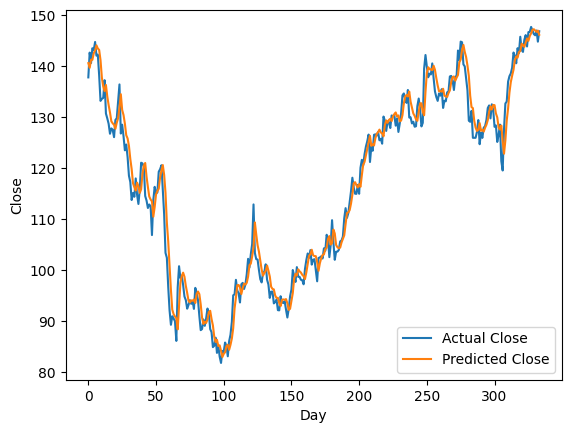

In [28]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()